<h1><b>1. Exploratory Data Analysis</b></h1>
<p>Let's first import the required libraries for this chapter.</p>

In [2]:
%matplotlib inline

from pathlib import Path

import pandas as pd
import numpy as np
from scipy.stats import trim_mean
from statsmodels import robust
import wquantiles

import seaborn as sns
import matplotlib.pylab as plt

In [3]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

<p>We are going to use many datasets. Since we've already stored them in the same directory as our code, we can use the same path names.</p>

In [30]:
AIRLINE_STATS_CSV = DATA / 'airline_stats.csv'
KC_TAX_CSV = DATA / 'kc_tax.csv.gz'
LC_LOANS_CSV = DATA / 'lc_loans.csv'
AIRPORT_DELAYS_CSV = DATA / 'dfw_airline.csv'
SP500_DATA_CSV = DATA / 'sp500_data.csv.gz'
SP500_SECTORS_CSV = DATA / 'sp500_sectors.csv'
STATE_CSV = DATA / 'state.csv'

<h2>1.1 Estimates of Location</h2>
<h3>Example - Location Estimates of Population and Murder Rates</h3>
<p><strong>Table 1-2.</strong> 2010 Census containing population and murder rates (units of murders per 100,000 people per year) for each state.

In [31]:
df_state = pd.read_csv(STATE_CSV)
print(df_state.head(10))

         State  Population  Murder.Rate Abbreviation
0      Alabama     4779736          5.7           AL
1       Alaska      710231          5.6           AK
2      Arizona     6392017          4.7           AZ
3     Arkansas     2915918          5.6           AR
4   California    37253956          4.4           CA
5     Colorado     5029196          2.8           CO
6  Connecticut     3574097          2.4           CT
7     Delaware      897934          5.8           DE
8      Florida    18801310          5.8           FL
9      Georgia     9687653          5.7           GA


<p> Let's compute the mean.</p>

In [32]:
df_state['Population'].mean()

6162876.3

<p>To compute the trimmed mean we can use <code>trim_mean</code> from <code>scipy.stats</code>:</p>

In [33]:
print(trim_mean(df_state['Population'], 0.1))

4783697.125


<p>Ok! Now, how about computing the median?</p>

In [34]:
print(df_state['Population'].median())

4436369.5


<p>Since <code>trim_mean</code> with a 10% (0.1) drop, which consists of removing 5 states from each end of the dataset population-wise, excludes the extremes, we get a smaller value when comparing with the mean.</p>
<p>To compute the average murder rate for the country, we need to use a <strong>weighted average</strong> to take into account the different demographics of each state.</p>

In [35]:
print(df_state['Murder.Rate'].mean())

4.066


In [36]:
# Use weighted mean with np.average
print(np.average(df_state['Murder.Rate'], weights=df_state['Population']))

4.445833981123393


To get the <strong>weighted median</strong>, use the <code>wquantiles</code> package.</p>

In [37]:
print(wquantiles.median(df_state['Murder.Rate'], weights=df_state['Population']))

4.4


<div style="background: lightblack; 
            font-size: 16px; 
            padding: 10px; 
            border: 1px solid lightgray; 
            margin: 10px;">
  <h4><strong>Takeaways:</strong></h4>
<ul>
<li>Although the mean is the basic metric for location, it can be sensitive to extreme values.</li>
<li>Other metrics such as the median and the trimmed mean are more robust since they are not as affected by outliers.</li>
</ul>
</p>
</div>

<hr>
<h2>1.2 Estimates of Variability</h2>
<h3>1.2.1 Standard Deviation and Related Estimates</h3>

In [38]:
print(df_state.head(10))

         State  Population  Murder.Rate Abbreviation
0      Alabama     4779736          5.7           AL
1       Alaska      710231          5.6           AK
2      Arizona     6392017          4.7           AZ
3     Arkansas     2915918          5.6           AR
4   California    37253956          4.4           CA
5     Colorado     5029196          2.8           CO
6  Connecticut     3574097          2.4           CT
7     Delaware      897934          5.8           DE
8      Florida    18801310          5.8           FL
9      Georgia     9687653          5.7           GA


<p><i>Table 1-3. 2010 Census containing population and murder rates (units of murders per 100,000 people per year) for each state</i>.

<p>Let's calculate the standard deviation.</p>

In [39]:
print(df_state['Population'].mean())

6162876.3


In [40]:
print(df_state['Population'].std())

6848235.347401142


<p>Calculating the <strong>interquantile range</strong> - we must find the difference between the 75th and the 25th quantile.</p>

In [41]:
print(df_state['Population'].quantile(0.75) - df_state['Population'].quantile(0.25))

4847308.0


<p>When it comes to the <strong>median absolute deviation (MAD)</strong>, we can obtain it by using the function <code>robust.scale</code> from the <code>statsmodels</code> package.</p>

In [42]:
print(robust.scale.mad(df_state['Population']))
print(abs(df_state['Population'] - df_state['Population'].median()).median()/ 0.6744897501960817)

3849876.1459979336
3849876.1459979336


<div style="background: lightblack; 
            font-size: 16px; 
            padding: 10px; 
            border: 1px solid lightgray; 
            margin: 10px;">
  <h4><strong>Takeaways:</strong></h4>
<ul>
<li><strong>Variance</strong> and <strong>standard deviation</strong> are very relevant as statistics of variability - both are <strong>very sensitive</strong> to extreme measures.</li>
<li>More robust metrics - Mean absolute deviation, MAD, and percentiles.</li>
</ul>
</p>
</div>

<hr>
<h2>1.3 Exploring the Data Distribution</h2>
<h3>1.3.1 Percentiles and Boxplots</h3>
<p>We can use the <code>pandas</code> <code>quantile</code> method to get the distribution of data in percentiles:</p>
<h4>Percentiles</h4>

In [43]:
# Percentiles
print(df_state['Murder.Rate'].quantile([0.05, 0.25, 0.5, 0.75, 0.95]))

0.05    1.600
0.25    2.425
0.50    4.000
0.75    5.550
0.95    6.510
Name: Murder.Rate, dtype: float64


In [44]:
percentages = [0.05, 0.25, 0.5, 0.75, 0.95]
df = pd.DataFrame(df_state['Murder.Rate'].quantile(percentages))
df.index = [f'{p * 100}%' for p in percentages]
print(df.transpose())

             5.0%  25.0%  50.0%  75.0%  95.0%
Murder.Rate   1.6  2.425    4.0   5.55   6.51


<p><i>Table 1-4. Percentiles of murder rate by US state.</i></p>

<p>We can see that the murder rate in the US displays a high variability. The 5th percentile is only 1.6 murders / 100,000 people, while the .95 quantile is 0.6510.
<h4>Boxplots</h4>

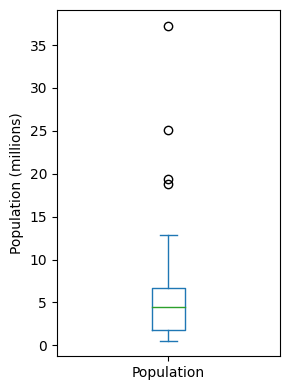

In [45]:
ax = (df_state['Population']/1_000_000).plot.box(figsize=(3, 4))
ax.set_ylabel('Population (millions)')

plt.tight_layout()
plt.show()

<p><i>Figure 1-2. Boxplot of state populations.</i></p>

<p><strong>Observations:</strong></p>
<ul>
<li>The median population is around 5 million.</li>
<li>Half the states fall between 2 and 7 million, approximately.</li>
<li>The top and the bottom are the 75th and the 25th percentiles.</li>
<li>The median is represented by the horizontal line in the box.</li>
<li>The lines, also called <i>whiskers</i>, extend from the top and bottom of the box to indicate the range for the bulk of the data.</li>
<li>Any data outside the wiskers is plotted as single circles and often represent <i>outliers</i>.</li>
</ul>

<h3>1.4.1 Frequency Tables and Histograms</h3>
<h4>Frequency Tables</h4>
<p>Use the <code>.cut()</code> function from <code>pandas</code> to create a series that maps the values into the segments. Coupled with <code>value_counts</code>, we can retrieve the frequency table:</p>


In [46]:
binned_population = pd.cut(df_state['Population'], 10)
print(binned_population.value_counts())

(526935.67, 4232659.0]      24
(4232659.0, 7901692.0]      14
(7901692.0, 11570725.0]      6
(11570725.0, 15239758.0]     2
(15239758.0, 18908791.0]     1
(18908791.0, 22577824.0]     1
(22577824.0, 26246857.0]     1
(33584923.0, 37253956.0]     1
(26246857.0, 29915890.0]     0
(29915890.0, 33584923.0]     0
Name: Population, dtype: int64


In [47]:
# Table 1.5
binned_population.name = 'binned_population'
df = pd.concat([df_state, binned_population], axis=1)
df = df.sort_values(by='Population')

groups = []
for group, subset in df.groupby(by='binned_population'):
    groups.append({
        'bin_range': group,
        'count': len(subset),
        'states': ','.join(subset.Abbreviation)
    })
print(pd.DataFrame(groups))

                  bin_range  count  \
0    (526935.67, 4232659.0]     24   
1    (4232659.0, 7901692.0]     14   
2   (7901692.0, 11570725.0]      6   
3  (11570725.0, 15239758.0]      2   
4  (15239758.0, 18908791.0]      1   
5  (18908791.0, 22577824.0]      1   
6  (22577824.0, 26246857.0]      1   
7  (26246857.0, 29915890.0]      0   
8  (29915890.0, 33584923.0]      0   
9  (33584923.0, 37253956.0]      1   

                                              states  
0  WY,VT,ND,AK,SD,DE,MT,RI,NH,ME,HI,ID,NE,WV,NM,N...  
1          KY,LA,SC,AL,CO,MN,WI,MD,MO,TN,AZ,IN,MA,WA  
2                                  VA,NJ,NC,GA,MI,OH  
3                                              PA,IL  
4                                                 FL  
5                                                 NY  
6                                                 TX  
7                                                     
8                                                     
9                              

<p><i>Table 1-5. A frequency table of population by state.</i></p>

<p><strong>Observations:</strong></p>
<ul>
<li>Wyoming is the least populous state, with 526,935 people, while California is the most populous, with 37,253,956 inhabitants.</li>
<li>This gives us a range of 36,727,021, which, divided by the 10 bins, result in a value of 3,672,702.1.</li>
<li>Although the two bins below California are empty, it is important to include empty bins, as they provide useful information.</li>
</ul>
<h4>Histogram</h4>


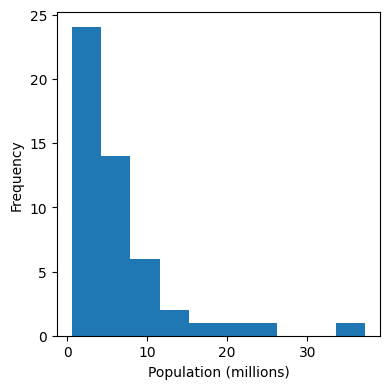

In [48]:
ax = (df_state['Population'] / 1_000_000).plot.hist(figsize=(4, 4))
ax.set_xlabel('Population (millions)')

plt.tight_layout()
plt.show()

<p><i>Figure 1-3. Histogram of state populations.</i></p>

<h4>Density Plots and Estimates</h4>
<p>Think about it as a smoothed histogram, although it is typically computed directly from the data through a <i>kernel density estimate</i>.</p>

Text(0.5, 0, 'Murder Rate (per 100,000)')

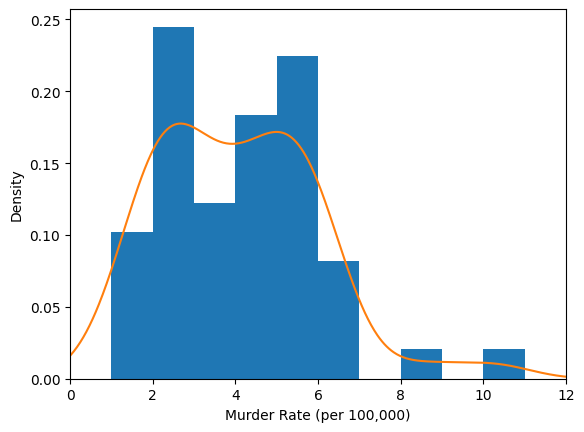

In [49]:
ax = df_state['Murder.Rate'].plot.hist(density=True, xlim=[0,12], bins=range(1,12))
df_state['Murder.Rate'].plot.density(ax=ax)
ax.set_xlabel('Murder Rate (per 100,000)')

<p><i>Figure 1-4. Density of state mruder rates</i></p>
<p>Note that the <strong>scale of the y-axis</strong> represents a proportion, and not the frequency. The total area under the density curve equals 1.</p>

<div style="background: lightblack; 
            font-size: 16px; 
            padding: 10px; 
            border: 1px solid lightgray; 
            margin: 10px;">
  <h4><strong>Takeaways:</strong></h4>
<ul>
<li>A< strong>frequency histogram</strong> plots frequency <strong>counts</strong> on the y-axis and <strong>variable values</strong> on the x-axis, giving a sense of the distribution of the data at a glance.</li>
<li>A <strong>frequency table</strong> is a tabular version of the histogram.</li>
<li>The <strong>boxplot</strong> also provides a quick view of the distribution of the data.</li>
<li>The <strong>density plot</strong> is a smoothed version of the histogram, requiring a function to estimate a plot based on the data.</li>
</ul>
</p>
</div>

<hr>
<h2>1.5 Exploring Binary and Categorical Data</h2>


In [50]:
# Table 1-6
df_airport_delays = pd.read_csv(AIRPORT_DELAYS_CSV)
print(100 * df_airport_delays / df_airport_delays.values.sum())

     Carrier        ATC   Weather  Security    Inbound
0  23.022989  30.400781  4.025214  0.122937  42.428079


<p><i>Table 1-6. Percentage of delays by cause at Dallas/Fort Worth Airport</i></p>

<p>Use <code>pandas</code> <code>.plot.bar()</code> to visualize bar charts for DataFrames:</p>

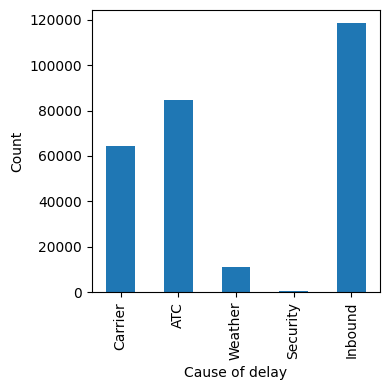

In [51]:
ax = df_airport_delays.transpose().plot.bar(figsize=(4, 4), legend=False)
ax.set_xlabel('Cause of delay')
ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

<p><i>Figure 1-5. Bar chart of airline delas at DFW by cause</i></p>

<div style="background: lightblack; 
            font-size: 16px; 
            padding: 10px; 
            border: 1px solid lightgray; 
            margin: 10px;">
  <h4><strong>Takeaways:</strong></h4>
<ul>
<li><strong>Categorical data</strong> - summed up in proportions, visualized in a bar chart.</li>
<li>Categories can represent <strong>distinct things</strong> (apples/oranges), <strong>levels of a factor variable</strong> (low, medium, high), or numeric data that has been <strong>binned</strong>.</li>
<li><strong>Expected value</strong> - sum of values times their <strong>probability of occurrence</strong>.</li>
</ul>
</p>
</div>
<h4>
<h2>1.6 Correlation</h2>

In [52]:
df_telecom_stocks_sym = pd.read_csv(SP500_SECTORS_CSV)
df_telecom_stocks_px = pd.read_csv(SP500_DATA_CSV, index_col=0)

In [53]:
# Table 1-7
# Determine the telecom symbols
telecom_symbols = df_telecom_stocks_sym[df_telecom_stocks_sym['sector'] == 'telecommunications_services']['symbol']

# Filter data for dates between July 2012 and June 2015
telecom = df_telecom_stocks_px.loc[df_telecom_stocks_px.index >= '2012-07-01', telecom_symbols]
telecom.corr()


,T,CTL,FTR,VZ,LVLT
T,1.000000,0.474683,0.327767,0.677612,0.278626
CTL,0.474683,1.000000,0.419757,0.416604,0.286665
FTR,0.327767,0.419757,1.000000,0.287386,0.260068
VZ,0.677612,0.416604,0.287386,1.000000,0.242199
LVLT,0.278626,0.286665,0.260068,0.242199,1.000000


<p><i>Table 1-7. Correlation between telecommunication stock returns</i></p>
<p>Note that <strong>ATT (T)</strong> and <strong>Verizon (VZ)</strong> display the highest correlation.</p>
<p>We can also use <strong>heat maps</strong> to visualize correlation matrices. Let's analyse the correlation between daily returns for major exchange-trade funds (ETFs):</p> 

In [54]:
etfs = df_telecom_stocks_px.loc[df_telecom_stocks_px.index > '2012-07-01',
                                df_telecom_stocks_sym[df_telecom_stocks_sym['sector'] == 'etf']['symbol']]
print(etfs.head())

                 XLI       QQQ       SPY       DIA       GLD    VXX       USO  \
2012-07-02 -0.376098  0.096313  0.028223 -0.242796  0.419998 -10.40  0.000000   
2012-07-03  0.376099  0.481576  0.874936  0.728405  0.490006  -3.52  0.250000   
2012-07-05  0.150440  0.096313 -0.103487  0.149420  0.239991   6.56 -0.070000   
2012-07-06 -0.141040 -0.491201  0.018819 -0.205449 -0.519989  -8.80 -0.180000   
2012-07-09  0.244465 -0.048160 -0.056445 -0.168094  0.429992  -0.48  0.459999   

                 IWM       XLE       XLY       XLU       XLB       XTL  \
2012-07-02  0.534641  0.028186  0.095759  0.098311 -0.093713  0.019076   
2012-07-03  0.926067  0.995942  0.000000 -0.044686  0.337373  0.000000   
2012-07-05 -0.171848 -0.460387  0.306431 -0.151938  0.103086  0.019072   
2012-07-06 -0.229128  0.206706  0.153214  0.080437  0.018744 -0.429213   
2012-07-09 -0.190939 -0.234892 -0.201098 -0.035751 -0.168687  0.000000   

                 XLV       XLP       XLF       XLK  
2012-07-02 -0.0

<p>We can use <code>seaborn.heatmap</code> to visualize the heatmap:</code>

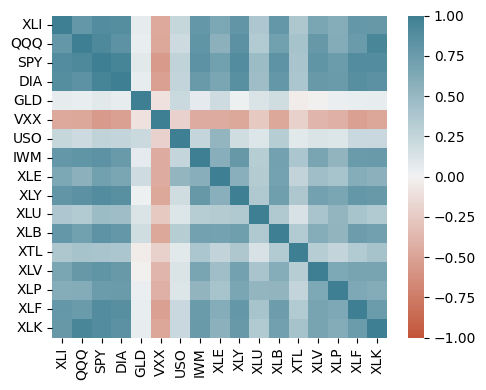

In [55]:
fig, ax = plt.subplots(figsize=(5, 4))
ax = sns.heatmap(etfs.corr(), vmin=-1, vmax=1,
                cmap=sns.diverging_palette(20, 220, as_cmap=True),
                ax=ax)

plt.tight_layout()
plt.show()

<p>Let's employ ellipses to better visualize correlations according to which direction they point:</p>

In [56]:
from matplotlib.collections import EllipseCollection
from matplotlib.colors import Normalize

def plot_corr_ellipses(data, figsize=None, **kwargs):
    '''Plots a correlation matrix as a set of ellipses. See https://stackoverflow.com/a/34556180'''
    M = np.array(data)
    if not M.ndim == 2:
        raise ValueError('data must be a 2D array')
    fig, ax = plt.subplots(1, 1, figsize=figsize, subplot_kw={'aspect': 'equal'})
    ax.set_xlim(-0.5, M.shape[1] - 0.5)
    ax.set_ylim(-0.5, M.shape[0] - 0.5)
    ax.invert_xaxis()

    # xy locations of each ellipse center
    xy = np.indices(M.shape)[::-1].reshape(2, -1).T

    # Set the relative sizes of the major/minor axes according to the strength
    # of the positive/negative correlation
    w = np.ones_like(M).ravel() + 0.01
    h = 1 - np.abs(M).ravel() - 0.01
    a = 45 * np.sign(M).ravel()

    ec = EllipseCollection(widths=w, heights=h, angles=a, units='x', offsets=xy,
                           norm=Normalize(vmin=-1, vmax=1),
                           transOffset=ax.transData, array=M.ravel(), **kwargs)
    ax.add_collection(ec)

    # If data is a DataFrame, use the row/column names as tick labels
    if isinstance(data, pd.DataFrame):
        ax.set_xticks(np.arange(M.shape[1]))
        ax.set_xticklabels(data.columns, rotation=90)
        ax.set_yticks(np.arange(M.shape[0]))
        ax.set_yticklabels(data.index)

    return ec, ax

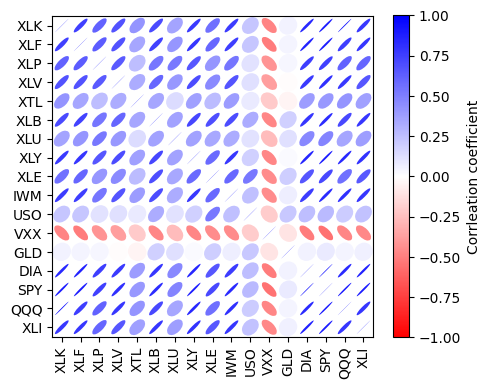

In [57]:
m, ax = plot_corr_ellipses(etfs.corr(), figsize=(5, 4), cmap='bwr_r')
cb = fig.colorbar(m, ax=ax)
cb.set_label('Corrleation coefficient')

plt.tight_layout()
plt.show()

<p><i>Figure 1-6. Correlation between ETF returns</i></p>
<p>The shading and width of the ellipse indicate the strength of the association: thinner and darker ellipses correspond to stronger relationship. We can see that ETFs such as SPY (S&P 500) and XLK (composed mostly of tech companys) display a high correlation, while more defensive assets, such as gold (GLD) and oil (USO) have a weak correlation with ETFs. Market volatility (VXX), on the other hand, present a negative correlation with most assets.</p>
<hr>
<h3>1.6.1 Scatterplots</h3>
<p>Using <code>pandas</code>, specify the marker as <code>$\u25EF$</code> to visualize it as an open circle for each point.</p>


In [58]:
telecom.head(20)

,T,CTL,FTR,VZ,LVLT
2012-07-02,0.422496,0.140847,0.070879,0.554180,-0.519998
2012-07-03,-0.177448,0.066280,0.070879,-0.025976,-0.049999
2012-07-05,-0.160548,-0.132563,0.055128,-0.051956,-0.180000
2012-07-06,0.342205,0.132563,0.007875,0.140106,-0.359999
2012-07-09,0.136883,0.124279,-0.023626,0.253943,0.180000
2012-07-10,-0.222436,-0.190559,-0.031502,-0.175133,-0.619999
2012-07-11,-0.136883,0.356260,0.039377,0.140106,-0.030001
2012-07-12,-0.145439,0.265126,-0.007875,0.017510,0.080000
2012-07-13,0.359315,0.546823,-0.094506,0.420316,0.190001
2012-07-16,0.171101,0.356264,0.015751,0.131350,0.100000


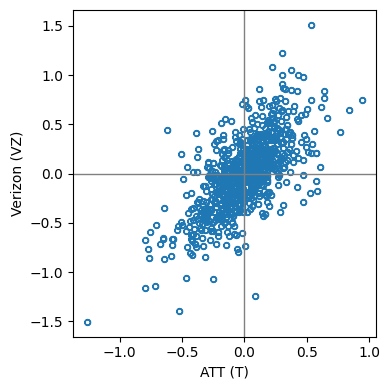

In [31]:
ax = telecom.plot.scatter(x='T', y='VZ', figsize=(4, 4), marker='$\u25EF$')
ax.set_xlabel('ATT (T)')
ax.set_ylabel('Verizon (VZ)')
ax.axhline(0, color='grey', lw=1)
ax.axvline(0, color='grey', lw=1)

plt.tight_layout()
plt.show()

<p>We can make the circles transparent to improve the visualization of the data around zero by assigning <code>alpha=0.5</code>.</p>

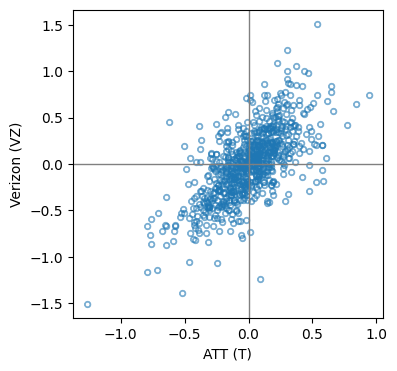

In [32]:
ax = telecom.plot.scatter(x='T', y='VZ', figsize=(4, 4), marker='$\u25EF$', alpha=0.5)
ax.set_xlabel('ATT (T)')
ax.set_ylabel('Verizon (VZ)')
ax.axhline(0, color='grey', lw=1)
ax.axvline(0, color='grey', lw=1)

<p><i>Figure 1-7. Scatterplot of correlation between returns for ATT and Verizon</i></p>
<p>We can observe that the returns for the two stocks display a positive correlation; only in a few cases one return is significantly different from the other, correlation-wise.</p>

<div style="background: lightblack; 
            font-size: 16px; 
            padding: 10px; 
            border: 1px solid lightgray; 
            margin: 10px;">
  <h4><strong>Takeaways:</strong></h4>
<ul>
<li>The <strong>correlation coefficient</strong> is a standardized metric, so that it always ranges from <strong>–1 (perfect negative correlation)</strong> to <strong>+1 (perfect positive correlation)</strong>. 
<li>While a correlation coefficient of <strong>zero</strong> indicates no correlation, be aware that aleatory arrangements of data will produce <i>both</i> positive and negative values for the coefficient just by chance.</li>
</ul>
</p>
</div>
<hr>
<h2>1.7 Exploring Two or More Variables</h2>

<p>Types of analysis according to the number of variables:</p>
<ul>
<li><strong>univariate analysis</strong> - look at variables <strong>one</strong> at a time (e.g. mean and variance)</li>
<li><strong>bivariate analysis</strong> - compares <strong>two</strong> variables at a time (e.g. correlation)</li>
<li><strong>multivariate analysis</strong> - compares <strong>more than two</strong> variables at a time</li>
</ul>

<p>Let's load the <code>kc_tax</code> dataset, which contains the tax-assessed values for residential properties in King County, Washington. We'll filter the data and remove extremes to get the main idea of the dataset.</p>

In [33]:
kc_tax = pd.read_csv(KC_TAX_CSV)
kc_tax0 = kc_tax.loc[(kc_tax['TaxAssessedValue'] < 750000) &
                     (kc_tax['SqFtTotLiving'] > 100) &
                     (kc_tax['SqFtTotLiving'] < 3500), :]
print(kc_tax0.shape)

(432693, 3)


<h3>1.7.1 Hexagonal Binning and Contours (Plotting Numeric vs Numeric Data)</h3>

<p>When the number of data points no longer represents any meaningul value due to large scale, density-related methods of visualization are helpful. We can use the <code>.hexbin()</code> method for pandas <code>DataFrames</code>:</p>

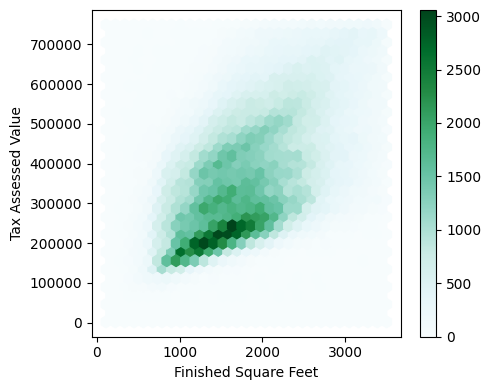

In [34]:
ax = kc_tax0.plot.hexbin(x='SqFtTotLiving', y='TaxAssessedValue',
                         gridsize=30, sharex=False, figsize=(5, 4))
ax.set_xlabel('Finished Square Feet')
ax.set_ylabel('Tax Assessed Value') 

plt.tight_layout()
plt.show()

<p><i>Figure 1-8. Hexagonal binning for tax-assessed value versus finished square feet</i></p>
<p>The color indicate the number of records in a given bin. We can visualize a positive relationship between square feet and tax assessed value. In addition, the three additional bands above the darkest band hint at houses with same footage having different prices. This indicates that there are different markets for houses with relatively similar prices.</p>
<p>We can also use contours overlaid onto a scatterplot to observe the relationship between two numeric variables. These contour bands indicate specific point densities, which increase as nearing a peak. For that, we can use seaborn's <code>kdeplot</code> as an extension of the density plot. Because the calculation can take several minutes, we can use a smaller sample of the dataset to make it quicker and get similar results while preserving the overall shape.</p>

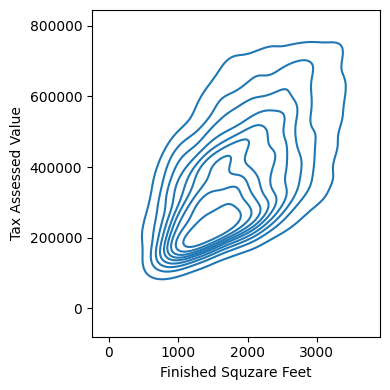

In [35]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.kdeplot(data=kc_tax0.sample(10000), x='SqFtTotLiving', y='TaxAssessedValue', ax=ax)
ax.set_xlabel('Finished Squzare Feet')
ax.set_ylabel('Tax Assessed Value')

plt.tight_layout()
plt.show()

<h3>1.7.2 Two Categorical Variables</h3>
<p><strong>Contingency tables</strong> are a great way to summarize the relationship between two categorical variables. Let`s load the <code>lc_loans</code> dataset containing data from a lending company.</p>

In [36]:
lc_loans = pd.read_csv(LC_LOANS_CSV)

In [39]:
# Table 1-8(1)
crosstab = lc_loans.pivot_table(index='grade', columns='status',
            aggfunc=lambda x: len(x), margins=True) # margins=True returns sum of rows and columns
print(crosstab)

status  Charged Off  Current  Fully Paid  Late     All
grade                                                 
A              1562    50051       20408   469   72490
B              5302    93852       31160  2056  132370
C              6023    88928       23147  2777  120875
D              5007    53281       13681  2308   74277
E              2842    24639        5949  1374   34804
F              1526     8444        2328   606   12904
G               409     1990         643   199    3241
All           22671   321185       97316  9789  450961


In [38]:
# Table 1-8(2)
df = crosstab.copy().loc['A':'G',:]
df.loc[:,'Charged Off': 'Late'] = df.loc[:,'Charged Off': 'Late'].div(df['All'], axis=0)
df['All'] = df['All'] / sum(df['All'])
perc_crosstab = df
print(perc_crosstab)

status  Charged Off   Current  Fully Paid      Late       All
grade                                                        
A          0.021548  0.690454    0.281528  0.006470  0.160746
B          0.040054  0.709013    0.235401  0.015532  0.293529
C          0.049828  0.735702    0.191495  0.022974  0.268039
D          0.067410  0.717328    0.184189  0.031073  0.164708
E          0.081657  0.707936    0.170929  0.039478  0.077177
F          0.118258  0.654371    0.180409  0.046962  0.028614
G          0.126196  0.614008    0.198396  0.061401  0.007187


<h3>1.7.3 Categorical and Numeric Data</h3>
<p><strong>Boxplots</strong> represent a good way to visualize the distributions of a numeric variable grouped according to a categorical variable. In the following example, we can compare the percentage of flight delays across several airline companies.</p>
<p>We can use pandas' <code>boxplot</code> to group the data by a column.</p>

In [40]:
airline_stats = pd.read_csv(AIRLINE_STATS_CSV)
airline_stats.head()

,pct_carrier_delay,pct_atc_delay,pct_weather_delay,airline
0,8.153226,1.971774,0.762097,American
1,5.959924,3.706107,1.585878,American
2,7.157270,2.706231,2.026706,American
3,12.100000,11.033333,0.000000,American
4,7.333333,3.365591,1.774194,American


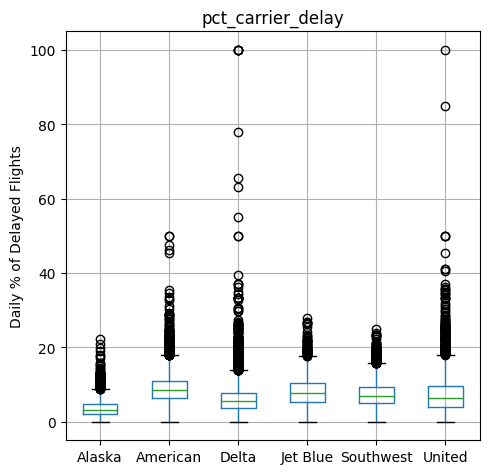

In [41]:
ax = airline_stats.boxplot(by='airline', column='pct_carrier_delay', figsize=(5, 5))
ax.set_xlabel('')
ax.set_ylabel('Daily % of Delayed Flights')
plt.suptitle('')

plt.tight_layout()
plt.show()

<p><i>Figure 1-10. Boxplot of percent of airline delays by carrier</i></p>
<p>We can observe that Alaska has the fewest number of delays, while American stands out as having the highest number of delays.</p>
<p><strong>Violin plots</strong> are an improvement over boxplots and allow us to observe the density on the y-axis. As such, we get a more nuanced view on the distribution of data.</p>

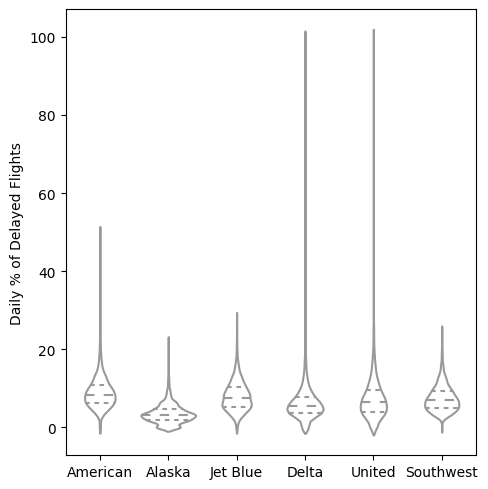

In [42]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.violinplot(data=airline_stats, x='airline', y='pct_carrier_delay',
               ax=ax, inner='quartile', color='white')

ax.set_xlabel('')
ax.set_ylabel('Daily % of Delayed Flights')

plt.tight_layout()
plt.show()

<p><i>Figure 1-11. Violin plot of percent of airline delays by carrier</i></p>
<p>Taking Alaska once again as an example, we can see a concentration in the distribution near zero.</p>
<h3>1.7.4 Visualizing Multiple Variables</h3>
<p>When using multiple variables, we can employ the concept of <i>conditioning</i> to apply related charts and compare more than one variable.</p>
<p>Let's go back again to our dataset on real estate and analyse those distribution bands that we had seen back then.</p>

In [43]:
zip_codes = [98188, 98105, 98108, 98126]
kc_tax_zip = kc_tax0.loc[kc_tax0.ZipCode.isin(zip_codes),:]
kc_tax_zip

,TaxAssessedValue,SqFtTotLiving,ZipCode
3,361000.0,2000,98108.0
4,459000.0,3150,98108.0
10,202000.0,830,98108.0
11,210000.0,1130,98108.0
12,193000.0,1560,98108.0
...,...,...,...
498049,346000.0,1430,98105.0
498050,463000.0,1610,98105.0
498051,553000.0,1580,98105.0
498052,571000.0,1840,98105.0


In [44]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=25, cmap=cmap, **kwargs)

c:\Users\Felipe\python_work\notebooks\py_practical_statistics\practical_statistics\lib\site-packages\seaborn\axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Felipe\python_work\notebooks\py_practical_statistics\practical_statistics\lib\site-packages\seaborn\axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Felipe\python_work\notebooks\py_practical_statistics\practical_statistics\lib\site-packages\seaborn\axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Felipe\python_work\notebooks\py_practical_statistics\practical_statistics\lib\site-packages\seaborn\axisgrid.py:745: FutureWarning: iteritems is deprecated a

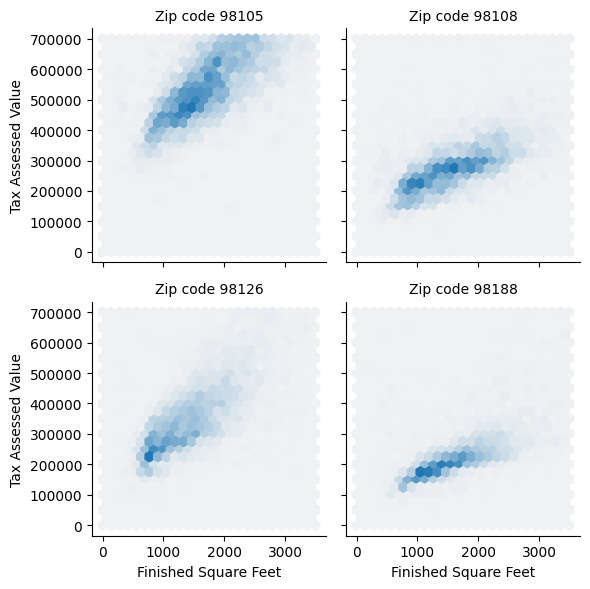

In [46]:
g = sns.FacetGrid(kc_tax_zip, col='ZipCode', col_wrap=2)
g.map(hexbin, 'SqFtTotLiving', 'TaxAssessedValue',
      extent=[0, 3500, 0, 700000])
g.set_axis_labels('Finished Square Feet', 'Tax Assessed Value')
g.set_titles('Zip code {col_name:.0f}')

plt.tight_layout()
plt.show()

<p><i>Figure 1-12. Tax-assessed value versus finished square feet by zip code</i></p>
<p>As we can see, there are different distribution of prices according to the four zip codes. Houses offered in the 98105 zip code display a higher value when compared with the remaining three codes.</p>

<div style="background: lightblack; 
            font-size: 16px; 
            padding: 10px; 
            border: 1px solid lightgray; 
            margin: 10px;">
  <h4><strong>Takeaways:</strong></h4>
<ul>
<li><strong>Hexagonal binning and contour plots</strong> - good for summarizing lots of data in a small space.
</li> 
<li><strong>Contingency tables</strong> - useful when comparing two categorical variables.</li>
<li><strong>Boxplots and violin plots</strong> - your choice of visualization when comparing a numeric and a categorical variable.</li>
</ul>
</p>
</div>
<p>Well, that was it. Visualizing, getting acquainted with the data with which you'll be dealing is an essential first step. This chapter covered lots of important tools and resources that can assist us on this task.</p>
</hr>